## Multimodal Retrieval Augmented Generation (RAG) with ImageBind
This example explores preparing, embedding, and storing both text and image data within a KDB.AI vector database. Our goal is to store both images and text within the same vector space so we can search over both modalities at the same time. KDB.AI can then be used as a retrieval tool within a RAG pipeline for both text and images, making it a multimodal retriever. 

The dataset we are working with contains images of several different animals, and text descriptions of those animals. After implementation, a user should be able to write a query regarding any of these animals and get returned both images and text related to the animal of interest.

The method in this notebook uses a multimodal embedding model from Meta called "ImageBind" to embed both text and images within the same vector space.

### Agenda:
0. Setup
1. Helper Functions
2. Prepare Data
3. Embed Texts and Images
4. Set Up KDB.AI Vector Database table
5. Insert data into KDB.AI Vector Database
6. Query Vector Database to Retrieve Most Relevant Data
7. Retrieval Augmented Generation
8. Drop the table

###### ImageBind Citation:
@inproceedings{girdhar2023imagebind,
  title={ImageBind: One Embedding Space To Bind Them All},
  author={Girdhar, Rohit and El-Nouby, Alaaeldin and Liu, Zhuang
and Singh, Mannat and Alwala, Kalyan Vasudev and Joulin, Armand and Misra, Ishan},
  booktitle={CVPR},
  year={2023}
}

ImageBind GitHub Repository: https://github.com/facebookresearch/ImageBind

Animal Images Source: https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals


## 0. Setup
 Install ImageBind requirements and import necessary packages 

In [1]:
!git clone https://github.com/facebookresearch/ImageBind

Cloning into 'ImageBind'...


In [2]:
import os
os.chdir('./ImageBind')

In [ ]:
!pip install .

In [14]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import os
import PIL
from PIL import Image
import torch
from imagebind import data
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

Instantiate the ImageBind model:

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Instantiate model
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)

100%|██████████████████████████████████████████████████████████████████| 4.47G/4.47G [01:48<00:00, 44.4MB/s]


ImageBindModel(
  (modality_preprocessors): ModuleDict(
    (vision): RGBDTPreprocessor(
      (cls_token): tensor((1, 1, 1280), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Sequential(
          (0): PadIm2Video()
          (1): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
      )
      (pos_embedding_helper): SpatioTemporalPosEmbeddingHelper(
        (pos_embed): tensor((1, 257, 1280), requires_grad=True)
        
      )
    )
    (text): TextPreprocessor(
      (pos_embed): tensor((1, 77, 1024), requires_grad=True)
      (mask): tensor((77, 77), requires_grad=False)
      
      (token_embedding): Embedding(49408, 1024)
    )
    (audio): AudioPreprocessor(
      (cls_token): tensor((1, 1, 768), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10), bias=False)
        (norm_layer): LayerNorm((768,), eps=1e-05, elementwise_affine=

## 1. Helper Functions
getEmbeddingVector: Runs data inputs through ImageBind and extracts the vector embedding

dataToEmbedding: Takes in the image or text file path and the data type and returns an embedded vector

queryToEmbedding:Takes a users query and returns an embedded query vector

read_text_from_file: Takes in text file and returns the text within that file

In [6]:
#Helper functions to create embeddings
def getEmbeddingVector(inputs):
    with torch.no_grad():
        embedding = model(inputs)
    for key, value in embedding.items():
        vec = value.reshape(-1)
        vec = vec.numpy()
        return(vec)

def dataToEmbedding(path,dtype):    
    data_path = [path]
    if dtype == 'image':
        inputs = {
        ModalityType.VISION: data.load_and_transform_vision_data(data_path, device)
        }
    elif dtype == 'text':
        inputs = {
        ModalityType.TEXT: data.load_and_transform_text(data_path, device)
        }
    vec = getEmbeddingVector(inputs)
    return(vec)

# Helper function to create a query vector from a natural language query    
def queryToEmbedding(text):
    text = [text]
    inputs = {
        ModalityType.TEXT: data.load_and_transform_text(text, device)
    }
    vec = getEmbeddingVector(inputs)
    return(vec)

# Helper function to read the text from a file
def read_text_from_file(filename):
    try:
        # Open the file in read mode ('r')
        with open(filename, 'r') as file:
            # Read the contents of the file into a string
            text = file.read()
        return text
    except IOError as e:
        # Handle any I/O errors
        print(f"An error occurred: {e}")
        return None
    

## 2. Prepare Data
Define an empty dataframe to store embeddings and get a list of paths for images and text files

In [7]:
#Define a dataframe to put our embeddings and metadata into - this will later be used to load our vector database
columns = ['path','media_type','embeddings']
df = pd.DataFrame(columns=columns)

In [8]:
#Get a list of paths for images, text
images = os.listdir("../data/images")
texts = os.listdir("../data/text")

## 3. Embed Texts and Images
Loop through all images and texts, send them to helper functions to be embedded by ImageBind model

In [16]:
#loop through images, append a row in the dataframe containing each image's path, media_type (image), and embeddings
for image in images:
    path = "../data/images/" + image
    media_type = "image"
    embedding = dataToEmbedding(path,media_type)
    new_row = {'path': path,
               'media_type':media_type,
               'embeddings':embedding}
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

In [17]:
#Look at the shape of out df after loading in image embeddings
df.shape

(12, 3)

In [18]:
#Explore the df
df.head()

,path,media_type,embeddings
0,../data/images/bat1.jpg,image,"[-0.00034329382, 0.025712004, -0.018437484, -0..."
1,../data/images/bat2.jpg,image,"[-0.0102536, 0.013193971, -0.004215549, 0.0116..."
2,../data/images/bear1.jpg,image,"[0.014970251, -0.011263397, -0.026858507, -0.0..."
3,../data/images/bear2.jpg,image,"[-0.0041088634, 0.0205412, -0.0037767396, -0.0..."
4,../data/images/caterpillar1.jpg,image,"[0.032080155, 0.014477748, 0.035794426, -0.019..."


In [19]:
#loop through texts, append a row in the dataframe containing each text's path, media_type (text), and embeddings
for text in texts:
    path = "../data/text/" + text
    media_type = "text"
    embedding = dataToEmbedding(path,media_type)
    new_row = {'path': path,
               'media_type':media_type,
               'embeddings':embedding}
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

In [20]:
#Look at the shape of out df after loading in text embeddings
df.shape

(18, 3)

In [21]:
#Explore the entire dataframe
df

,path,media_type,embeddings
0,../data/images/bat1.jpg,image,"[-0.00034329382, 0.025712004, -0.018437484, -0..."
1,../data/images/bat2.jpg,image,"[-0.0102536, 0.013193971, -0.004215549, 0.0116..."
2,../data/images/bear1.jpg,image,"[0.014970251, -0.011263397, -0.026858507, -0.0..."
3,../data/images/bear2.jpg,image,"[-0.0041088634, 0.0205412, -0.0037767396, -0.0..."
4,../data/images/caterpillar1.jpg,image,"[0.032080155, 0.014477748, 0.035794426, -0.019..."
5,../data/images/caterpillar2.jpg,image,"[-0.0024396114, 0.017810782, 0.024738714, -0.0..."
6,../data/images/deer1.jpg,image,"[0.008055295, 0.005556237, 0.045033008, 0.0091..."
7,../data/images/deer2.jpg,image,"[0.025239633, -0.0017763185, 0.006584649, 0.01..."
8,../data/images/fox1.jpg,image,"[0.0074821454, -0.01673528, 0.031439118, -0.00..."
9,../data/images/fox2.jpg,image,"[0.03498491, -0.016432308, 0.00794267, 0.01514..."


## 4. Set Up KDB.AI Vector Database table
Time to get KDB.AI vector database set up. If you do not have an account, go to KDB.AI to sign-up free!

In [22]:
# vector DB imports
import os
from getpass import getpass
import kdbai_client as kdbai
import time

In [44]:
#Set up KDB.AI endpoing and API key
KDBAI_ENDPOINT = (
    os.environ["KDBAI_ENDPOINT"]
    if "KDBAI_ENDPOINT" in os.environ
    else input("KDB.AI endpoint: ")
)
KDBAI_API_KEY = (
    os.environ["KDBAI_API_KEY"]
    if "KDBAI_API_KEY" in os.environ
    else getpass("KDB.AI API key: ")
)

KDB.AI endpoint: your_kdbai_endpoint
KDB.AI API key: ········


In [24]:
#connect to KDB.AI
session = kdbai.Session(api_key=KDBAI_API_KEY, endpoint=KDBAI_ENDPOINT)

In [25]:
#Set up a table with three columns, path, media_type, and embeddings
#In embeddings, we use 1024 dimensions because that is the dimensionality that ImageBind outputs
#Using Cosine Similarity as our similarity search method, and a flat index
table_schema = {
    "columns": [
        {"name": "path", "pytype": "str"},
        {"name": "media_type", "pytype": "str"},
        {
            "name": "embeddings",
            "pytype": "float32",
            "vectorIndex": {"dims": 1024, "metric": "CS", "type": "flat"},
        },
    ]
}

In [26]:
# First ensure the table does not already exist
try:
    session.table("multi_modal_demo").drop()
    time.sleep(5)
except kdbai.KDBAIException:
    pass

In [27]:
#Create the table called "metadata_demo"
table = session.create_table("multi_modal_demo", table_schema)

## 5. Insert data into KDB.AI Vector Database

In [28]:
#Insert the data into the table, split into 2000 row batches
from tqdm import tqdm 
n = 2000  # chunk row size

for i in tqdm(range(0, df.shape[0], n)):
    table.insert(df[i:i+n].reset_index(drop=True))

100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


In [29]:
#Explore what is in the table/vector database
table.query()

,path,media_type,embeddings
0,../data/images/bat1.jpg,image,"[-0.00034329382, 0.025712004, -0.018437484, -0..."
1,../data/images/bat2.jpg,image,"[-0.0102536, 0.013193971, -0.004215549, 0.0116..."
2,../data/images/bear1.jpg,image,"[0.014970251, -0.011263397, -0.026858507, -0.0..."
3,../data/images/bear2.jpg,image,"[-0.0041088634, 0.0205412, -0.0037767396, -0.0..."
4,../data/images/caterpillar1.jpg,image,"[0.032080155, 0.014477748, 0.035794426, -0.019..."
5,../data/images/caterpillar2.jpg,image,"[-0.0024396114, 0.017810782, 0.024738714, -0.0..."
6,../data/images/deer1.jpg,image,"[0.008055295, 0.005556237, 0.045033008, 0.0091..."
7,../data/images/deer2.jpg,image,"[0.025239633, -0.0017763185, 0.006584649, 0.01..."
8,../data/images/fox1.jpg,image,"[0.0074821454, -0.01673528, 0.031439118, -0.00..."
9,../data/images/fox2.jpg,image,"[0.03498491, -0.016432308, 0.00794267, 0.01514..."


## 6. Query Vector Database to Retrieve Most Relevant Data 
Our vector database now contains embeddings representing both text files and images! We can query the vector database to find the most relevant animal based on our query. 

Retrieved results can then be sent to an LLM for RAG

In [30]:
# Helper function to view the results of our similarity search
def viewResults(results):
    for index, row in results[0].iterrows():
        if row[1] == 'image':
            image = Image.open(row[0])
            display(image)
        elif row[1] == 'text':
            text = read_text_from_file(row[0])
            print(text)

In [31]:
#Create a query vector to do similarity search against
query_vector = [queryToEmbedding("large brown furry animal").tolist()]

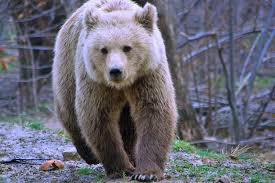

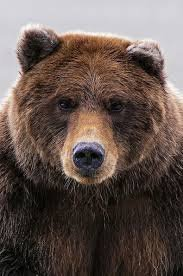

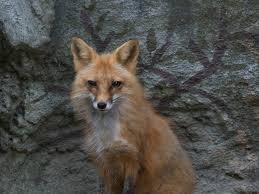

In [32]:
#Execute a similarity search
results = table.search(query_vector, n=3)
viewResults(results)

In [33]:
#Try another query
query_vector = [queryToEmbedding("brown animal with antlers").tolist()]

Deer are hoofed mammals known for their graceful bodies and long legs. Most male deer have antlers, which they shed and regrow annually. They are herbivores, generally feeding on a mix of grasses, plants, and leaves. Deer are found in various habitats across the world, including forests, grasslands, and wetlands.


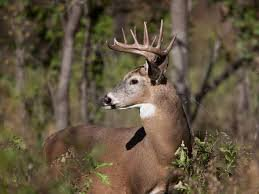

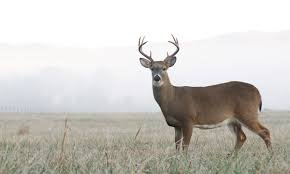

In [34]:
#Execute a similarity search
results = table.search(query_vector, n=3)
viewResults(results)

In [35]:
#Try another query
query_vector = [queryToEmbedding("green and yellow insect that cacoons").tolist()]

Caterpillars are the larval stage of butterflies and moths. They have a segmented body with a distinct head and typically several pairs of true legs, as well as additional false legs or prolegs. Caterpillars are primarily known for their voracious appetite, often eating leaves voraciously before pupating into their adult form.


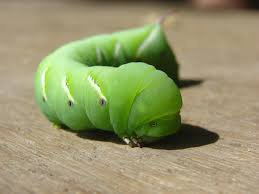

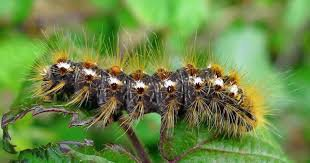

In [36]:
#Execute a similarity search
results = table.search(query_vector, n=3)
viewResults(results)

Now we have retrieved the most relevant text and images from KDB.AI vector database, the retrieval step of RAG is complete!

## 7. RAG Time!
We will use Google's Gemini Vision model to handle input text and images. We can now take our retrieved data and pass it to Gemini for the second phase of RAG: Generation

In [37]:
# Pip install necessary packages
!pip install google-generativeai langchain-google-genai streamlit pillow

In [38]:
# Setup Google API Key, get it here: https://makersuite.google.com/
os.environ["GOOGLE_API_KEY"] = (
    os.environ["GOOGLE_API_KEY"]
    if "GOOGLE_API_KEY" in os.environ
    else getpass("Google API Key: ")
)

Google API Key: ········


In [39]:
import google.generativeai as genai
genai.configure(api_key = os.environ['GOOGLE_API_KEY'])

In [40]:
# Use Gemini Pro Vision model to handle multimodal inputs
vision_model = genai.GenerativeModel('gemini-pro-vision')

In [41]:
# Helper function to get retrieved data ready to send to Gemini
def RAG_Setup(results,retrieved_data_for_RAG):
    for index, row in results[0].iterrows():
        if row[1] == 'image':
            image = PIL.Image.open(row[0])
            retrieved_data_for_RAG.append(image)
        elif row[1] == 'text':
            text = read_text_from_file(row[0])
            retrieved_data_for_RAG.append(text)
    return retrieved_data_for_RAG


Construct the query to send to Gemini:

In [42]:
prompt = "what can you tell me about caterpillars in the images? What species are they?"

#This will serve as the prompt being sent to Gemini:
query = "You will answer the given prompt using attached content: " + prompt

#Gemini accepts a list of inputs, which include texts and images retrieved from the vector database
#This input list will begin with the query defined above
RAG_list = [query]

#The input list and retrieved results are now passed into the RAG_Setup helper function
#retieved_data_for_RAG will now contain a list including the prompt and retrieved text/image data
retrieved_data_for_RAG = RAG_Setup(results, RAG_list)



Execute generation step of RAG:

In [43]:
#Gemini generates a response based on the retrieved_data_for_RAG input list, completing the RAG iteration
response = vision_model.generate_content(retrieved_data_for_RAG)
print(response.text)

 The first image appears to be a green caterpillar with black dots and a white stripe along its side. This is likely a tobacco hornworm, a common caterpillar found in North America. The second image is a hairy caterpillar with black and white markings. This is likely a fall webworm, a caterpillar that is found in North America and Europe.


## 8. Delete the KDB.AI Table
Once finished with the table, it is best practice to drop it.

In [ ]:
table.drop()